In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from google.colab import files

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Common parameters
b1, b2 = 1, 1
tha1, tha2 = 0.5, 0.5
thb1, thb2 = 0.07, 0.07
k1, k2 = 1, 1
n, m = 4, 1

# Time domain
t_start, t_end = 0.0, 10.0
n_points = 200
t_eval = np.linspace(t_start, t_end, n_points)
t_train = torch.linspace(t_start, t_end, n_points).view(-1, 1).to(device)

In [ ]:
# Numerical solution function
def numerical_solution(G0, P0, a1, a2):
    def ode_system(t, y):
        G, P = y
        dG = (a1 * G**n / (tha1**n + G**n)) + (b1 * thb1**m / (thb1**m + G**m * P**m)) - k1 * G
        dP = (a2 * P**n / (tha2**n + P**n)) + (b2 * thb2**m / (thb2**m + G**m * P**m)) - k2 * P
        return [dG, dP]

    start_time = time.time()
    sol = solve_ivp(ode_system, [t_start, t_end], [G0, P0], t_eval=t_eval, method='LSODA', rtol=1e-8)
    elapsed_time = time.time() - start_time

    return sol.y[0], sol.y[1], elapsed_time


In [ ]:
#uploading the custom radau and the trapzoidal as modules 
files.upload()

In [ ]:
from radau import solve_stem_cell_radau
from trap import solve_stem_cell_model


CASE 1
Computing LSODA solution for Case 1 (a1=1, a2=1)...
Computing Radau solution for Case 1 (a1=1, a2=1)...
Computing Trapezoidal solution for Case 1 (a1=1, a2=1)...

=== Training PINN for Case 1 (a1=1, a2=1) ===
Epoch 0, Loss: 21.291010, LR: 0.001000
  Physics Loss: 1.291010, IC Loss: 20.000000


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 500, Loss: 0.004257, LR: 0.001000
  Physics Loss: 0.000987, IC Loss: 0.003270
Epoch 1000, Loss: 0.000038, LR: 0.001000
  Physics Loss: 0.000038, IC Loss: 0.000000
Epoch 1500, Loss: 0.000321, LR: 0.001000
  Physics Loss: 0.000078, IC Loss: 0.000243
Epoch 2000, Loss: 0.000945, LR: 0.001000
  Physics Loss: 0.000050, IC Loss: 0.000895
Epoch 2500, Loss: 0.000016, LR: 0.000500
  Physics Loss: 0.000016, IC Loss: 0.000000
Epoch 3000, Loss: 0.000010, LR: 0.000500
  Physics Loss: 0.000010, IC Loss: 0.000000
Epoch 3500, Loss: 0.000006, LR: 0.000500
  Physics Loss: 0.000006, IC Loss: 0.000000
Epoch 4000, Loss: 0.000038, LR: 0.000500
  Physics Loss: 0.000017, IC Loss: 0.000022
Epoch 4500, Loss: 0.000005, LR: 0.000500
  Physics Loss: 0.000005, IC Loss: 0.000000
Epoch 5000, Loss: 0.000046, LR: 0.000500
  Physics Loss: 0.000010, IC Loss: 0.000035
Epoch 5500, Loss: 0.000004, LR: 0.000500
  Physics Loss: 0.000004, IC Loss: 0.000000
Epoch 6000, Loss: 0.000216, LR: 0.000500
  Physics Loss: 0.000037,

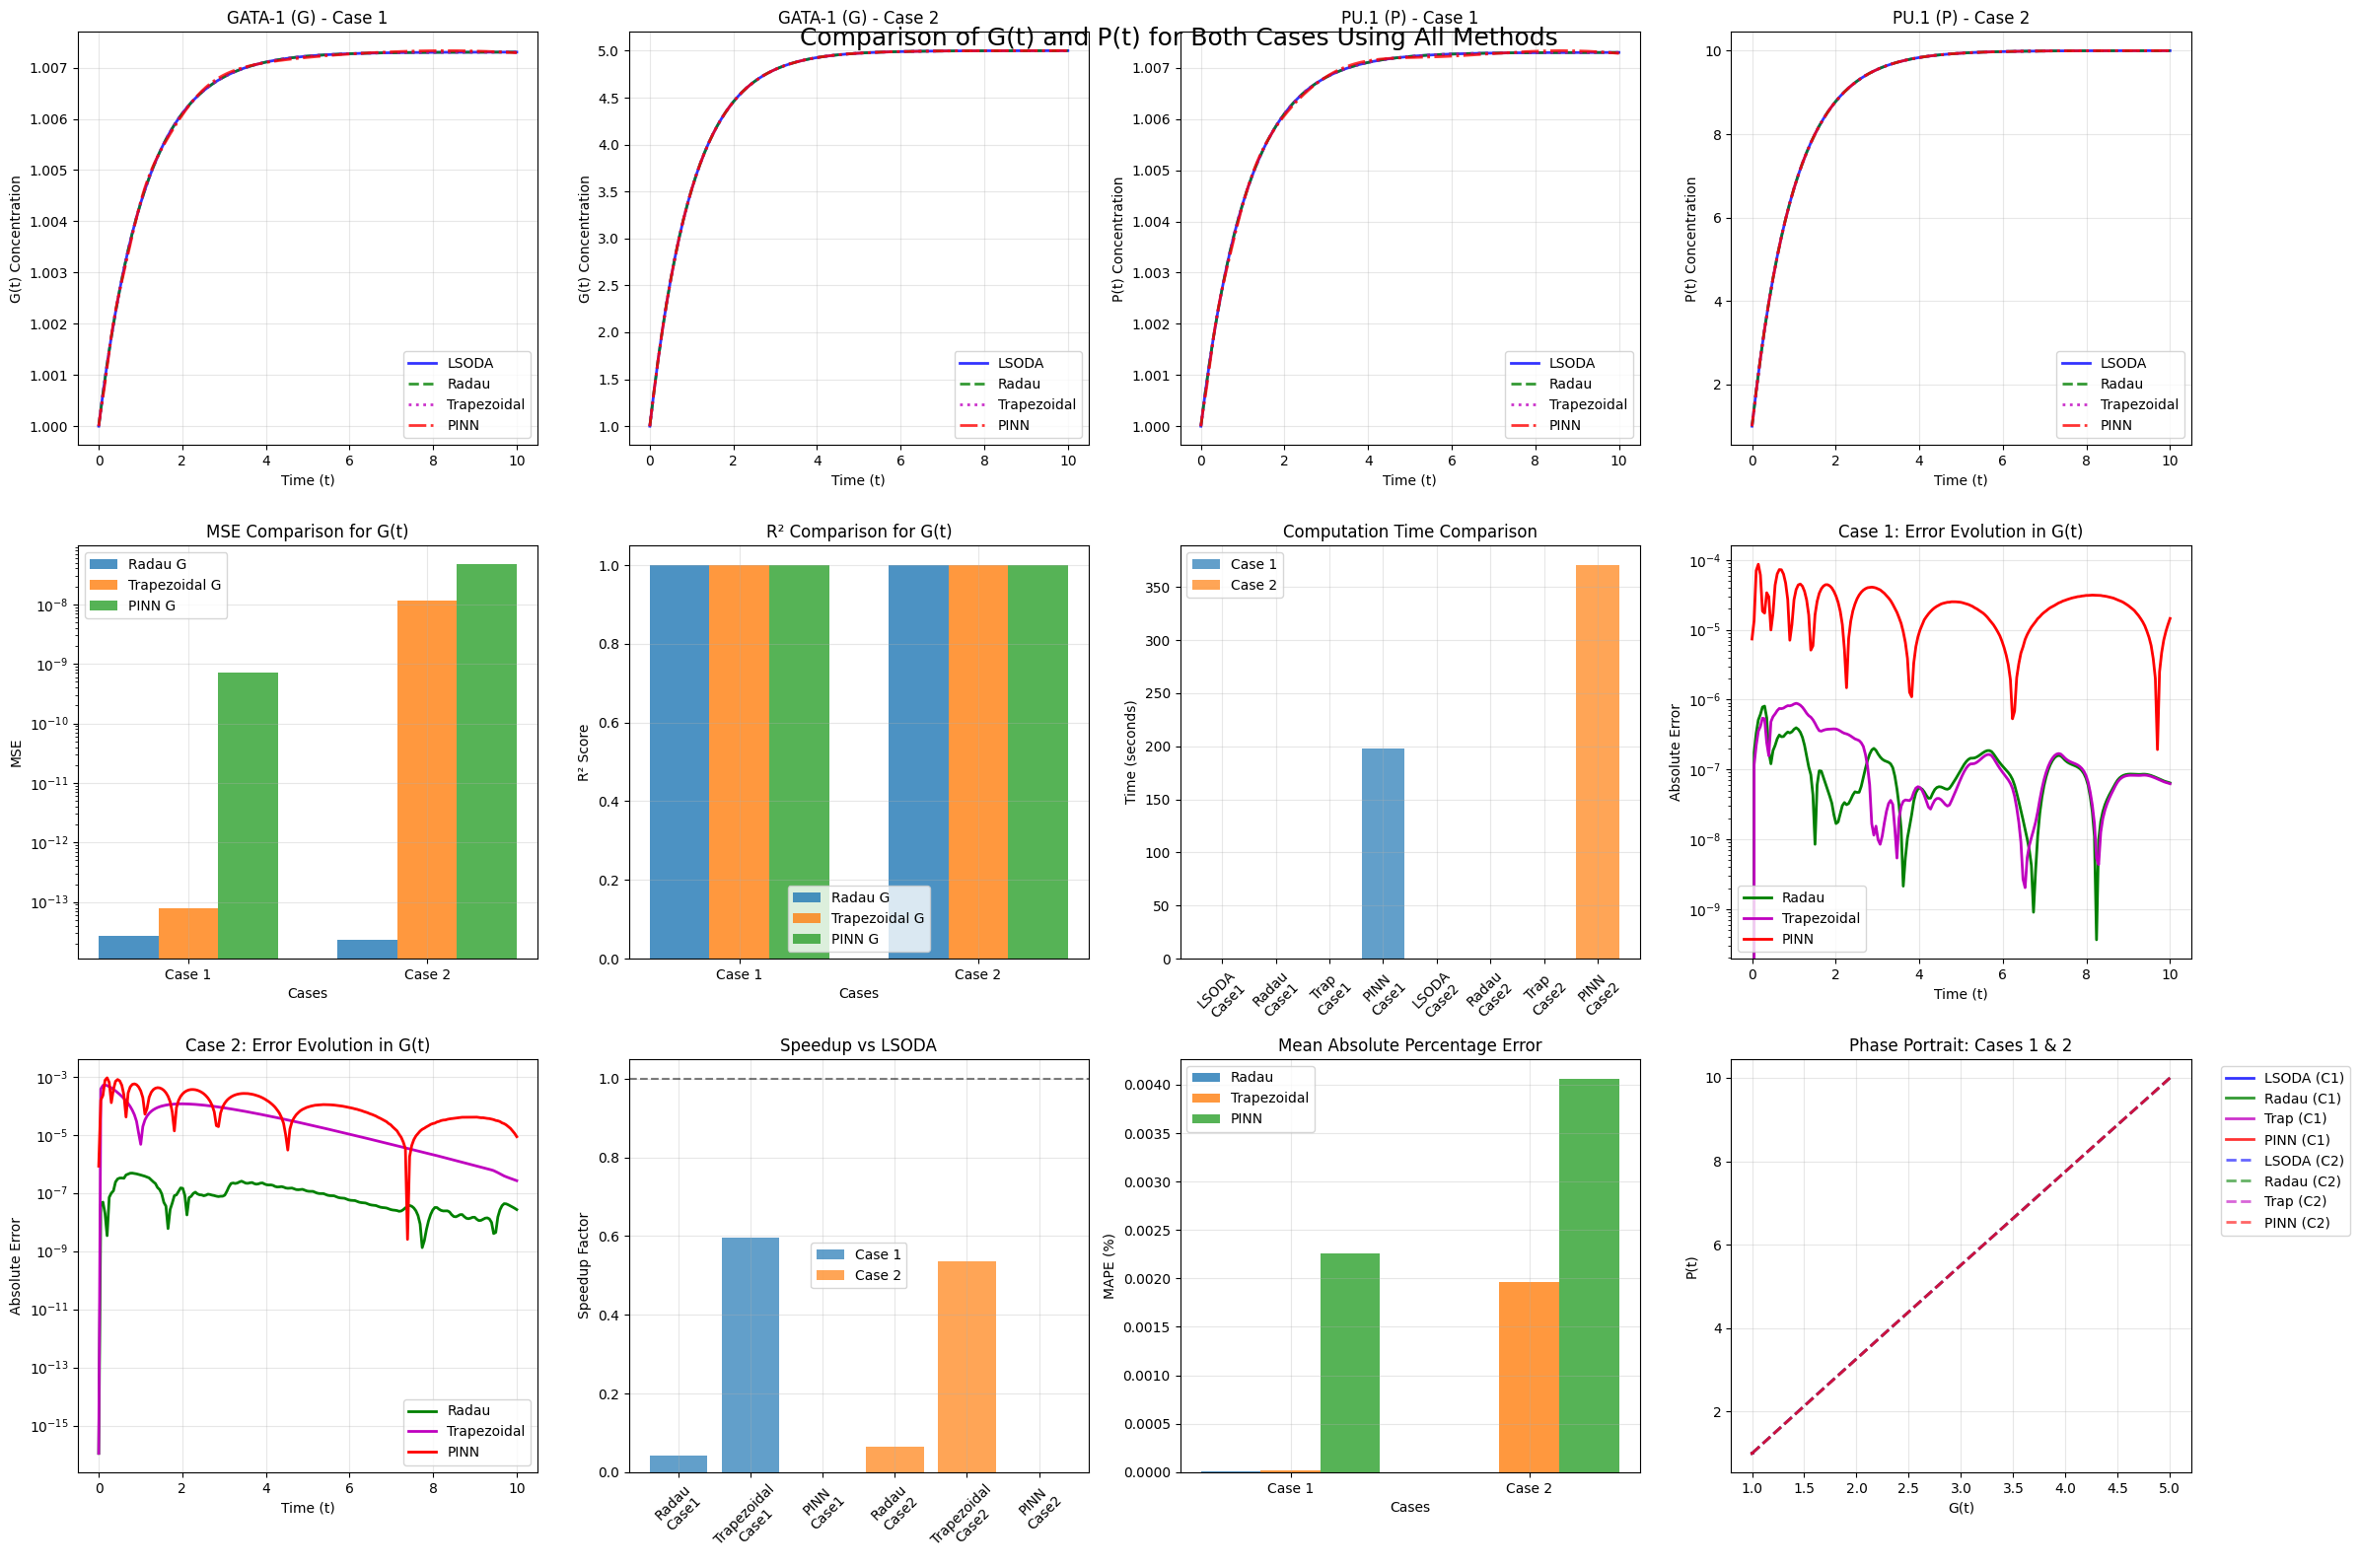

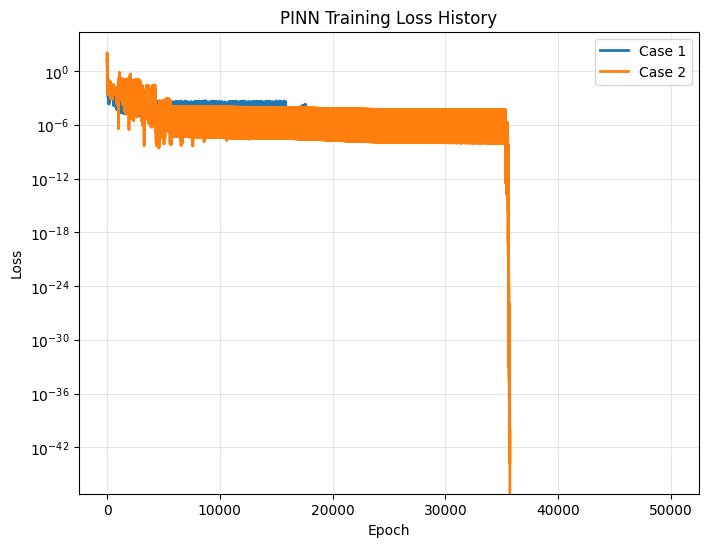


COMPREHENSIVE COMPARISON SUMMARY

--- CASE 1 DETAILED METRICS ---
Parameters: a1=1, a2=1

G(t) Metrics:
Method       MSE          MAE        RMSE       MAPE       R²       MaxAE      NRMSE     
------------------------------------------------------------------------------------------
Radau        2.74e-14     0.0000     0.0000     0.00       1.0000   0.0000     0.0000    
Trapezoidal  8.00e-14     0.0000     0.0000     0.00       1.0000   0.0000     0.0000    
PINN         7.26e-10     0.0000     0.0000     0.00       0.9997   0.0001     0.0037    

P(t) Metrics:
Method       MSE          MAE        RMSE       MAPE       R²       MaxAE      NRMSE     
------------------------------------------------------------------------------------------
Radau        2.74e-14     0.0000     0.0000     0.00       1.0000   0.0000     0.0000    
Trapezoidal  8.00e-14     0.0000     0.0000     0.00       1.0000   0.0000     0.0000    
PINN         9.24e-10     0.0000     0.0000     0.00       0.9996   

In [ ]:

# PINN Model
class PINN(nn.Module):
    def __init__(self, case_num):
        super().__init__()
        # Case-specific architecture
        if case_num == 1:
            # Simpler architecture for Case 1
            self.net = nn.Sequential(
                nn.Linear(1, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, 64),
                nn.Tanh(),
                nn.Linear(64, 2)
            )
        else:
            # More complex architecture for Case 2
            self.net = nn.Sequential(
                nn.Linear(1, 256),
                nn.Tanh(),
                nn.Linear(256, 256),
                nn.Tanh(),
                nn.Linear(256, 256),
                nn.Tanh(),
                nn.Linear(256, 128),
                nn.Tanh(),
                nn.Linear(128, 2)
            )

        # Initialize weights using Xavier initialization
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, t):
        return self.net(t)

# Physics Loss
def ode_residuals(model, t, a1, a2):
    t.requires_grad = True
    G_pred, P_pred = model(t).split(1, dim=1)

    dG_dt = torch.autograd.grad(G_pred, t, torch.ones_like(G_pred), create_graph=True)[0]
    dP_dt = torch.autograd.grad(P_pred, t, torch.ones_like(P_pred), create_graph=True)[0]

    f1 = (a1 * G_pred**n / (tha1**n + G_pred**n)) + (b1 * thb1**m / (thb1**m + G_pred**m * P_pred**m)) - k1 * G_pred
    f2 = (a2 * P_pred**n / (tha2**n + P_pred**n)) + (b2 * thb2**m / (thb2**m + G_pred**m * P_pred**m)) - k2 * P_pred

    res1 = dG_dt - f1
    res2 = dP_dt - f2

    return res1, res2, G_pred, P_pred

def train_pinn(G0, P0, a1, a2, case_name):
    print(f"\n=== Training PINN for {case_name} ===")

    # Determine case number from parameters
    case_num = 2 if a1 > 1 else 1

    model = PINN(case_num).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Case-specific learning rate scheduler
    if case_num == 1:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=500,
            verbose=True, min_lr=1e-5
        )
    else:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=1000,
            verbose=True, min_lr=1e-6
        )

    loss_fn = nn.MSELoss()

    start_time = time.time()
    loss_history = []

    # Case-specific number of epochs
    n_epochs = 30000 if case_num == 1 else 50000

    # Case-specific loss weights
    w_phys = 1.0
    w_ic = 10.0 if case_num == 1 else 5.0

    # Curriculum learning parameters (only for Case 2)
    curriculum_steps = 5 if case_num == 2 else 1
    current_step = 0

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Curriculum learning only for Case 2
        if case_num == 2 and epoch % (n_epochs // curriculum_steps) == 0 and current_step < curriculum_steps:
            current_step += 1
            t_end_curr = t_end * (current_step / curriculum_steps)
            t_train_curr = torch.linspace(t_start, t_end_curr, n_points).view(-1, 1).to(device)
        else:
            t_train_curr = t_train

        resG, resP, G_pred, P_pred = ode_residuals(model, t_train_curr, a1, a2)

        # Case-specific loss computation
        loss_phys = w_phys * (loss_fn(resG, torch.zeros_like(resG)) + loss_fn(resP, torch.zeros_like(resP)))

        # Initial condition loss
        t0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True).to(device)
        G0_pred, P0_pred = model(t0).split(1, dim=1)
        loss_ic = w_ic * (loss_fn(G0_pred, torch.tensor([[G0]], dtype=torch.float32, device=device)) +
                          loss_fn(P0_pred, torch.tensor([[P0]], dtype=torch.float32, device=device)))

        # Adaptive weighting only for Case 2
        if case_num == 2 and epoch > 1000:
            w_phys = min(1.0, loss_ic.item() / (loss_phys.item() + 1e-8))
            w_ic = min(10.0, loss_phys.item() / (loss_ic.item() + 1e-8))

        loss = loss_phys + loss_ic
        loss.backward()

        # Gradient clipping with case-specific thresholds
        max_norm = 0.5 if case_num == 1 else 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)

        optimizer.step()
        scheduler.step(loss)

        loss_history.append(loss.item())

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
            print(f"  Physics Loss: {loss_phys.item():.6f}, IC Loss: {loss_ic.item():.6f}")
            if case_num == 2:
                print(f"  Weights - Physics: {w_phys:.2f}, IC: {w_ic:.2f}")

    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")

    # Evaluate
    model.eval()
    with torch.no_grad():
        pred = model(t_train).cpu().numpy()
    G_pred, P_pred = pred[:, 0], pred[:, 1]

    return G_pred, P_pred, elapsed_time, loss_history


def calculate_additional_metrics(true_vals, pred_vals):
    """Calculate comprehensive accuracy metrics"""
    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)

    # Basic metrics
    mse = np.mean((true_vals - pred_vals)**2)
    mae = np.mean(np.abs(true_vals - pred_vals))
    rmse = np.sqrt(mse)

    # Relative metrics
    mape = np.mean(np.abs((true_vals - pred_vals) / (true_vals + 1e-8))) * 100

    # R-squared
    ss_res = np.sum((true_vals - pred_vals)**2)
    ss_tot = np.sum((true_vals - np.mean(true_vals))**2)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))

    # Maximum absolute error
    max_ae = np.max(np.abs(true_vals - pred_vals))

    # Normalized RMSE
    nrmse = rmse / (np.max(true_vals) - np.min(true_vals) + 1e-8)

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'MaxAE': max_ae,
        'NRMSE': nrmse
    }
# Store results for both cases
results = {}

# Loop through both cases
for ncase in [1, 2]:
    print(f"\n{'='*50}")
    print(f"CASE {ncase}")
    print(f"{'='*50}")

    if ncase == 1:
        G0, P0, a1, a2 = 1, 1, 1, 1
    elif ncase == 2:
        G0, P0, a1, a2 = 1, 1, 5, 10

    case_name = f"Case {ncase} (a1={a1}, a2={a2})"

    # Numerical solution (LSODA - our reference/analytical solution)
    print(f"Computing LSODA solution for {case_name}...")
    G_lsoda, P_lsoda, time_lsoda = numerical_solution(G0, P0, a1, a2)

    # Custom Radau solution
    print(f"Computing Radau solution for {case_name}...")
    t = np.linspace(0,10,n_points)
    G_radau, P_radau, time_radau = solve_stem_cell_radau(ncase,t)

    # Custom Trapezoidal solution
    print(f"Computing Trapezoidal solution for {case_name}...")
    G_trap, P_trap, time_trap = solve_stem_cell_model(a1=a1,a2=a2,t_span=(0,10),t_eval=t)

    # PINN solution
    G_pinn, P_pinn, time_pinn, loss_history = train_pinn(G0, P0, a1, a2, case_name)

    # Calculate comprehensive metrics for all methods (using LSODA as reference)
    methods = {
        'Radau': {'G': G_radau, 'P': P_radau, 'time': time_radau},
        'Trapezoidal': {'G': G_trap, 'P': P_trap, 'time': time_trap},
        'PINN': {'G': G_pinn, 'P': P_pinn, 'time': time_pinn}
    }

    metrics = {}
    for method_name, method_data in methods.items():
        metrics[method_name] = {
            'G': calculate_additional_metrics(G_lsoda, method_data['G']),
            'P': calculate_additional_metrics(P_lsoda, method_data['P']),
            'time': method_data['time'],
            'speedup': time_lsoda / method_data['time']
        }

    # Store results
    results[ncase] = {
        't': t_eval,
        'G_lsoda': G_lsoda, 'P_lsoda': P_lsoda,
        'G_radau': G_radau, 'P_radau': P_radau,
        'G_trap': G_trap, 'P_trap': P_trap,
        'G_pinn': G_pinn, 'P_pinn': P_pinn,
        'time_lsoda': time_lsoda,
        'time_radau': time_radau,
        'time_trap': time_trap,
        'time_pinn': time_pinn,
        'metrics': metrics,
        'loss_history': loss_history,
        'params': f"a1={a1}, a2={a2}"
    }





# Create comprehensive comparison plots
fig = plt.figure(figsize=(24, 16))

colors = ['b-', 'g--', 'm:', 'r-.']
methods = ['LSODA', 'Radau', 'Trapezoidal', 'PINN']
G_keys = ['G_lsoda', 'G_radau', 'G_trap', 'G_pinn']
P_keys = ['P_lsoda', 'P_radau', 'P_trap', 'P_pinn']

# GATA-1 (G) - Case 1
plt.subplot(3, 4, 1)
data = results[1]
for key, method, color in zip(G_keys, methods, colors):
    plt.plot(data['t'], data[key], color, linewidth=2, label=method, alpha=0.8)
plt.xlabel('Time (t)')
plt.ylabel('G(t) Concentration')
plt.title('GATA-1 (G) - Case 1')
plt.legend()
plt.grid(True, alpha=0.3)

# GATA-1 (G) - Case 2
plt.subplot(3, 4, 2)
data = results[2]
for key, method, color in zip(G_keys, methods, colors):
    plt.plot(data['t'], data[key], color, linewidth=2, label=method, alpha=0.8)
plt.xlabel('Time (t)')
plt.ylabel('G(t) Concentration')
plt.title('GATA-1 (G) - Case 2')
plt.legend()
plt.grid(True, alpha=0.3)

# PU.1 (P) - Case 1
plt.subplot(3, 4, 3)
data = results[1]
for key, method, color in zip(P_keys, methods, colors):
    plt.plot(data['t'], data[key], color, linewidth=2, label=method, alpha=0.8)
plt.xlabel('Time (t)')
plt.ylabel('P(t) Concentration')
plt.title('PU.1 (P) - Case 1')
plt.legend()
plt.grid(True, alpha=0.3)

# PU.1 (P) - Case 2
plt.subplot(3, 4, 4)
data = results[2]
for key, method, color in zip(P_keys, methods, colors):
    plt.plot(data['t'], data[key], color, linewidth=2, label=method, alpha=0.8)
plt.xlabel('Time (t)')
plt.ylabel('P(t) Concentration')
plt.title('PU.1 (P) - Case 2')
plt.legend()
plt.grid(True, alpha=0.3)

# MSE Comparison Bar Chart for G(t)
plt.subplot(3, 4, 5)
cases = ['Case 1', 'Case 2']
methods_short = ['Radau', 'Trapezoidal', 'PINN']
x = np.arange(len(cases))
width = 0.25

for i, method in enumerate(methods_short):
    mse_G_vals = [results[case]['metrics'][method]['G']['MSE'] for case in [1, 2]]
    plt.bar(x + i*width, mse_G_vals, width, label=f'{method} G', alpha=0.8)

plt.xlabel('Cases')
plt.ylabel('MSE')
plt.title('MSE Comparison for G(t)')
plt.xticks(x + width, cases)
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

# R² Comparison for G(t)
plt.subplot(3, 4, 6)
for i, method in enumerate(methods_short):
    r2_G_vals = [results[case]['metrics'][method]['G']['R2'] for case in [1, 2]]
    plt.bar(x + i*width, r2_G_vals, width, label=f'{method} G', alpha=0.8)

plt.xlabel('Cases')
plt.ylabel('R² Score')
plt.title('R² Comparison for G(t)')
plt.xticks(x + width, cases)
plt.legend()
plt.grid(True, alpha=0.3)

# Computation Time Comparison
plt.subplot(3, 4, 7)
methods_all = ['LSODA', 'Radau', 'Trap', 'PINN']
for case in [1, 2]:
    data = results[case]
    times = [data['time_lsoda'], data['time_radau'], data['time_trap'], data['time_pinn']]
    plt.bar([f'{m}\nCase{case}' for m in methods_all], times,
            alpha=0.7, label=f'Case {case}')

plt.ylabel('Time (seconds)')
plt.title('Computation Time Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Error Evolution for Case 1
plt.subplot(3, 4, 8)
data = results[1]
for method, color in zip(['Radau', 'Trapezoidal', 'PINN'], ['g-', 'm-', 'r-']):
    if method == 'Radau':
        error = np.abs(data['G_lsoda'] - data['G_radau'])
    elif method == 'Trapezoidal':
        error = np.abs(data['G_lsoda'] - data['G_trap'])
    else:
        error = np.abs(data['G_lsoda'] - data['G_pinn'])
    plt.semilogy(data['t'], error, color, linewidth=2, label=f'{method}')
plt.xlabel('Time (t)')
plt.ylabel('Absolute Error')
plt.title('Case 1: Error Evolution in G(t)')
plt.legend()
plt.grid(True, alpha=0.3)

# Error Evolution for Case 2
plt.subplot(3, 4, 9)
data = results[2]
for method, color in zip(['Radau', 'Trapezoidal', 'PINN'], ['g-', 'm-', 'r-']):
    if method == 'Radau':
        error = np.abs(data['G_lsoda'] - data['G_radau'])
    elif method == 'Trapezoidal':
        error = np.abs(data['G_lsoda'] - data['G_trap'])
    else:
        error = np.abs(data['G_lsoda'] - data['G_pinn'])
    plt.semilogy(data['t'], error, color, linewidth=2, label=f'{method}')
plt.xlabel('Time (t)')
plt.ylabel('Absolute Error')
plt.title('Case 2: Error Evolution in G(t)')
plt.legend()
plt.grid(True, alpha=0.3)

# Speedup Analysis
plt.subplot(3, 4, 10)
for case in [1, 2]:
    speedups = [results[case]['metrics'][method]['speedup'] for method in methods_short]
    plt.bar([f'{m}\nCase{case}' for m in methods_short], speedups,
            alpha=0.7, label=f'Case {case}')
plt.ylabel('Speedup Factor')
plt.title('Speedup vs LSODA')
plt.xticks(rotation=45)
plt.axhline(y=1, color='k', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)

# MAPE Comparison
plt.subplot(3, 4, 11)
for i, method in enumerate(methods_short):
    mape_vals = [results[case]['metrics'][method]['G']['MAPE'] for case in [1, 2]]
    plt.bar(x + i*width, mape_vals, width, label=f'{method}', alpha=0.8)
plt.xlabel('Cases')
plt.ylabel('MAPE (%)')
plt.title('Mean Absolute Percentage Error')
plt.xticks(x + width, cases)
plt.legend()
plt.grid(True, alpha=0.3)

# Phase Portrait Comparison Combined (Case 1 and Case 2)
plt.subplot(3, 4, 12)
# Case 1 - solid lines
data = results[1]
plt.plot(data['G_lsoda'], data['P_lsoda'], 'b-', linewidth=2, label='LSODA (C1)', alpha=0.8)
plt.plot(data['G_radau'], data['P_radau'], 'g-', linewidth=2, label='Radau (C1)', alpha=0.8)
plt.plot(data['G_trap'], data['P_trap'], 'm-', linewidth=2, label='Trap (C1)', alpha=0.8)
plt.plot(data['G_pinn'], data['P_pinn'], 'r-', linewidth=2, label='PINN (C1)', alpha=0.8)

# Case 2 - dashed lines
data = results[2]
plt.plot(data['G_lsoda'], data['P_lsoda'], 'b--', linewidth=2, label='LSODA (C2)', alpha=0.6)
plt.plot(data['G_radau'], data['P_radau'], 'g--', linewidth=2, label='Radau (C2)', alpha=0.6)
plt.plot(data['G_trap'], data['P_trap'], 'm--', linewidth=2, label='Trap (C2)', alpha=0.6)
plt.plot(data['G_pinn'], data['P_pinn'], 'r--', linewidth=2, label='PINN (C2)', alpha=0.6)

plt.xlabel('G(t)')
plt.ylabel('P(t)')
plt.title('Phase Portrait: Cases 1 & 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Optional: Create a separate figure for PINN Loss History if needed
fig2 = plt.figure(figsize=(8, 6))
for case in [1, 2]:
    data = results[case]
    plt.semilogy(data['loss_history'], linewidth=2, label=f'Case {case}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PINN Training Loss History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# ADD COMPREHENSIVE SUMMARY TABLES
# =============================================================================

print(f"\n{'='*100}")
print("COMPREHENSIVE COMPARISON SUMMARY")
print(f"{'='*100}")

# Performance metrics table
for case in [1, 2]:
    print(f"\n--- CASE {case} DETAILED METRICS ---")
    print(f"Parameters: {results[case]['params']}")
    print(f"\nG(t) Metrics:")
    print(f"{'Method':<12} {'MSE':<12} {'MAE':<10} {'RMSE':<10} {'MAPE':<10} {'R²':<8} {'MaxAE':<10} {'NRMSE':<10}")
    print("-" * 90)

    for method in ['Radau', 'Trapezoidal', 'PINN']:
        metrics = results[case]['metrics'][method]['G']
        print(f"{method:<12} {metrics['MSE']:<12.2e} {metrics['MAE']:<10.4f} "
              f"{metrics['RMSE']:<10.4f} {metrics['MAPE']:<10.2f} {metrics['R2']:<8.4f} "
              f"{metrics['MaxAE']:<10.4f} {metrics['NRMSE']:<10.4f}")

    print(f"\nP(t) Metrics:")
    print(f"{'Method':<12} {'MSE':<12} {'MAE':<10} {'RMSE':<10} {'MAPE':<10} {'R²':<8} {'MaxAE':<10} {'NRMSE':<10}")
    print("-" * 90)

    for method in ['Radau', 'Trapezoidal', 'PINN']:
        metrics = results[case]['metrics'][method]['P']
        print(f"{method:<12} {metrics['MSE']:<12.2e} {metrics['MAE']:<10.4f} "
              f"{metrics['RMSE']:<10.4f} {metrics['MAPE']:<10.2f} {metrics['R2']:<8.4f} "
              f"{metrics['MaxAE']:<10.4f} {metrics['NRMSE']:<10.4f}")

# Timing comparison table
print(f"\n{'='*80}")
print("COMPUTATIONAL PERFORMANCE ANALYSIS")
print(f"{'='*80}")
print(f"{'Case':<6} {'Method':<12} {'Time (s)':<12} {'Speedup':<10} {'Efficiency':<12}")
print("-" * 80)

for case in [1, 2]:
    data = results[case]
    print(f"{case:<6} {'LSODA':<12} {data['time_lsoda']:<12.4f} {'1.00':<10} {'Reference':<12}")

    for method in ['Radau', 'Trap', 'PINN']:
        time_val = data[f'time_{method.lower()}']
        speedup = data['time_lsoda'] / time_val
        efficiency = "Faster" if speedup > 1 else "Slower"
        print(f"{'':6} {method:<12} {time_val:<12.4f} {speedup:<10.2f} {efficiency:<12}")

# Method ranking table
print(f"\n{'='*60}")
print("METHOD RANKING BY ACCURACY (Lower is Better)")
print(f"{'='*60}")

for case in [1, 2]:
    print(f"\nCase {case} Rankings:")

    # Rank by MSE for G
    methods_list = ['Radau', 'Trapezoidal', 'PINN']
    mse_g_values = [(method, results[case]['metrics'][method]['G']['MSE']) for method in methods_list]
    mse_g_values.sort(key=lambda x: x[1])

    print("G(t) - Ranked by MSE:")
    for i, (method, mse) in enumerate(mse_g_values, 1):
        print(f"  {i}. {method}: {mse:.2e}")

    # Rank by MSE for P
    mse_p_values = [(method, results[case]['metrics'][method]['P']['MSE']) for method in methods_list]
    mse_p_values.sort(key=lambda x: x[1])

    print("P(t) - Ranked by MSE:")
    for i, (method, mse) in enumerate(mse_p_values, 1):
        print(f"  {i}. {method}: {mse:.2e}")

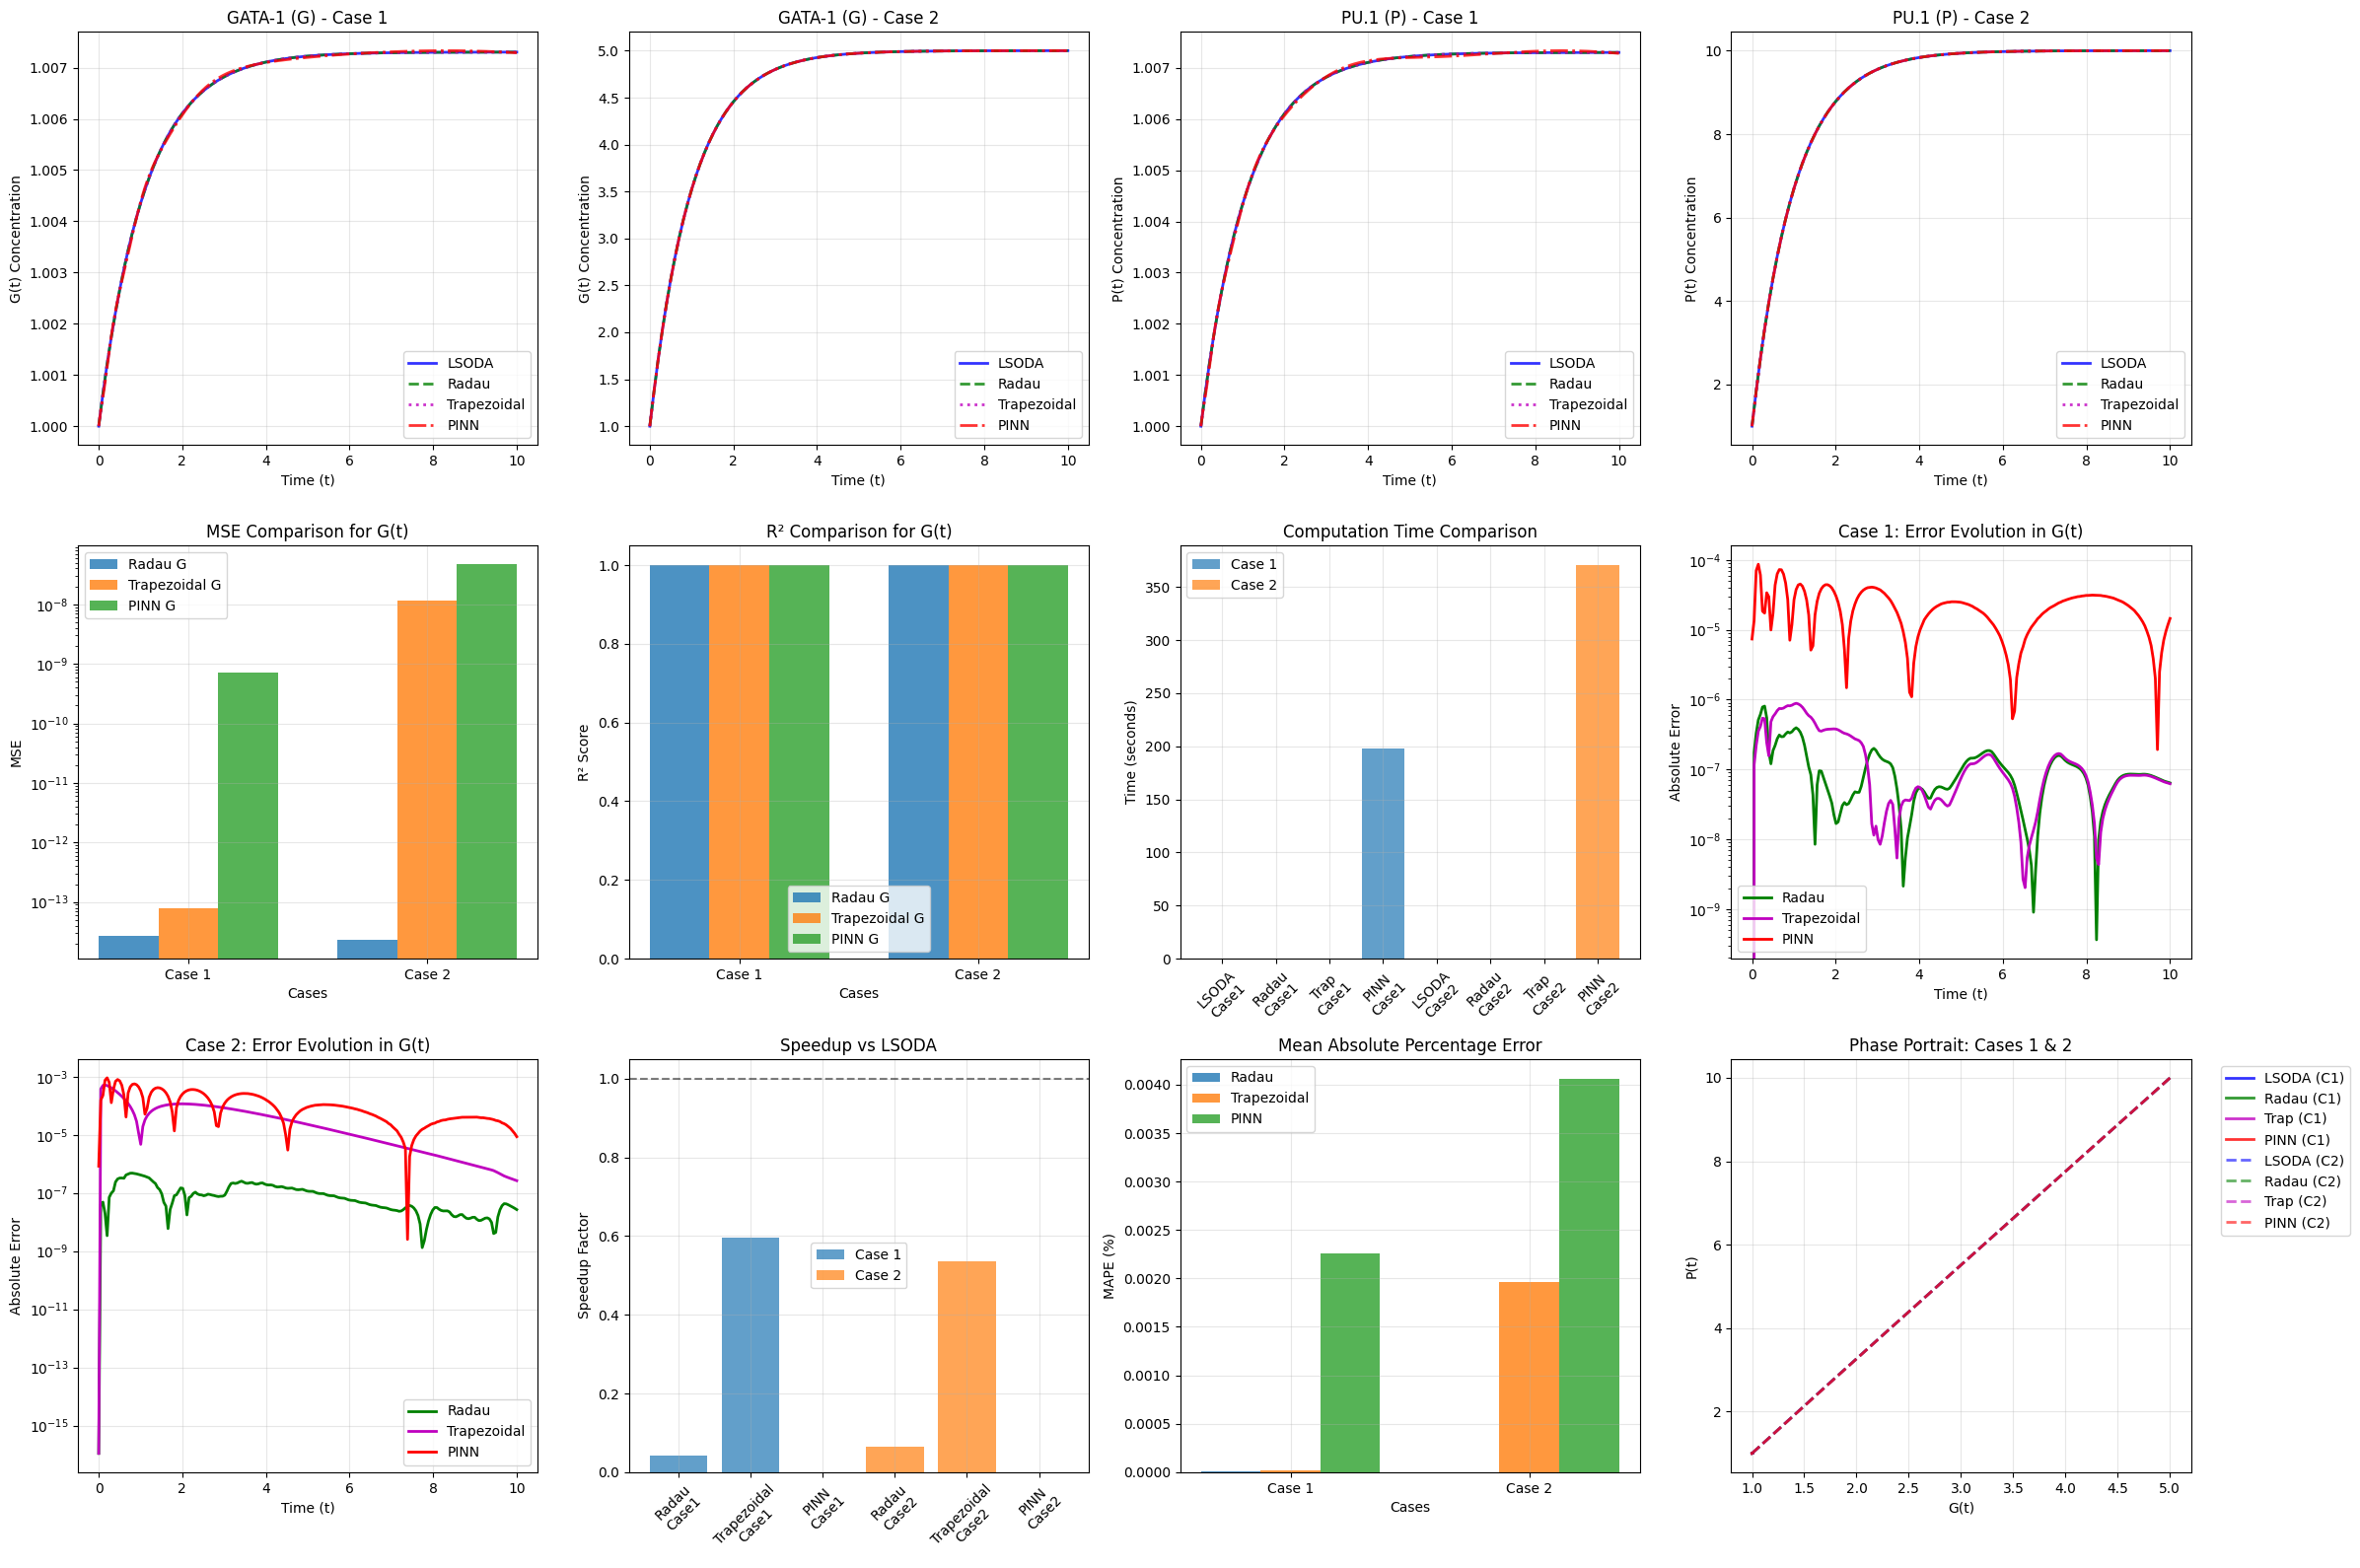

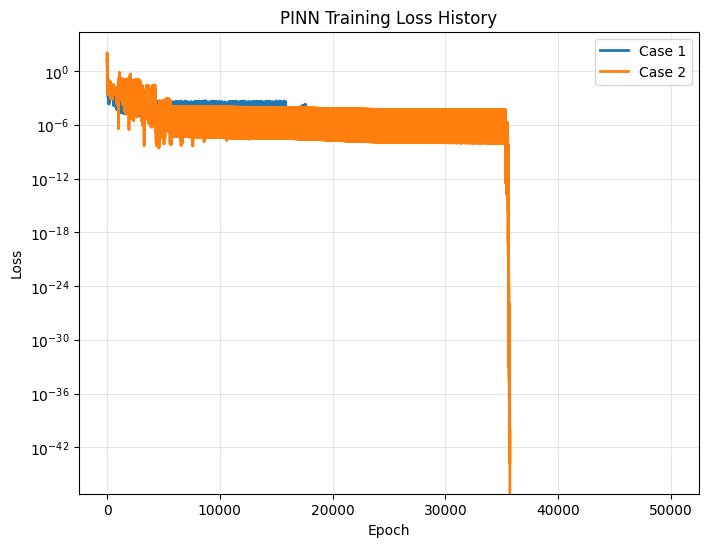


COMPREHENSIVE COMPARISON SUMMARY

--- CASE 1 DETAILED METRICS ---
Parameters: a1=1, a2=1

G(t) Metrics:
Method       MSE          MAE        RMSE       MAPE       R²       MaxAE      NRMSE     
------------------------------------------------------------------------------------------
Radau        2.74e-14     0.0000     0.0000     0.00       1.0000   0.0000     0.0000    
Trapezoidal  8.00e-14     0.0000     0.0000     0.00       1.0000   0.0000     0.0000    
PINN         7.26e-10     0.0000     0.0000     0.00       0.9997   0.0001     0.0037    

P(t) Metrics:
Method       MSE          MAE        RMSE       MAPE       R²       MaxAE      NRMSE     
------------------------------------------------------------------------------------------
Radau        2.74e-14     0.0000     0.0000     0.00       1.0000   0.0000     0.0000    
Trapezoidal  8.00e-14     0.0000     0.0000     0.00       1.0000   0.0000     0.0000    
PINN         9.24e-10     0.0000     0.0000     0.00       0.9996   

In [ ]:
fig = plt.figure(figsize=(24, 16))

colors = ['b-', 'g--', 'm:', 'r-.']
methods = ['LSODA', 'Radau', 'Trapezoidal', 'PINN']
G_keys = ['G_lsoda', 'G_radau', 'G_trap', 'G_pinn']
P_keys = ['P_lsoda', 'P_radau', 'P_trap', 'P_pinn']

# GATA-1 (G) - Case 1
plt.subplot(3, 4, 1)
data = results[1]
for key, method, color in zip(G_keys, methods, colors):
    plt.plot(data['t'], data[key], color, linewidth=2, label=method, alpha=0.8)
plt.xlabel('Time (t)')
plt.ylabel('G(t) Concentration')
plt.title('GATA-1 (G) - Case 1')
plt.legend()
plt.grid(True, alpha=0.3)

# GATA-1 (G) - Case 2
plt.subplot(3, 4, 2)
data = results[2]
for key, method, color in zip(G_keys, methods, colors):
    plt.plot(data['t'], data[key], color, linewidth=2, label=method, alpha=0.8)
plt.xlabel('Time (t)')
plt.ylabel('G(t) Concentration')
plt.title('GATA-1 (G) - Case 2')
plt.legend()
plt.grid(True, alpha=0.3)

# PU.1 (P) - Case 1
plt.subplot(3, 4, 3)
data = results[1]
for key, method, color in zip(P_keys, methods, colors):
    plt.plot(data['t'], data[key], color, linewidth=2, label=method, alpha=0.8)
plt.xlabel('Time (t)')
plt.ylabel('P(t) Concentration')
plt.title('PU.1 (P) - Case 1')
plt.legend()
plt.grid(True, alpha=0.3)

# PU.1 (P) - Case 2
plt.subplot(3, 4, 4)
data = results[2]
for key, method, color in zip(P_keys, methods, colors):
    plt.plot(data['t'], data[key], color, linewidth=2, label=method, alpha=0.8)
plt.xlabel('Time (t)')
plt.ylabel('P(t) Concentration')
plt.title('PU.1 (P) - Case 2')
plt.legend()
plt.grid(True, alpha=0.3)

# MSE Comparison Bar Chart for G(t)
plt.subplot(3, 4, 5)
cases = ['Case 1', 'Case 2']
methods_short = ['Radau', 'Trapezoidal', 'PINN']
x = np.arange(len(cases))
width = 0.25

for i, method in enumerate(methods_short):
    mse_G_vals = [results[case]['metrics'][method]['G']['MSE'] for case in [1, 2]]
    plt.bar(x + i*width, mse_G_vals, width, label=f'{method} G', alpha=0.8)

plt.xlabel('Cases')
plt.ylabel('MSE')
plt.title('MSE Comparison for G(t)')
plt.xticks(x + width, cases)
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

# R² Comparison for G(t)
plt.subplot(3, 4, 6)
for i, method in enumerate(methods_short):
    r2_G_vals = [results[case]['metrics'][method]['G']['R2'] for case in [1, 2]]
    plt.bar(x + i*width, r2_G_vals, width, label=f'{method} G', alpha=0.8)

plt.xlabel('Cases')
plt.ylabel('R² Score')
plt.title('R² Comparison for G(t)')
plt.xticks(x + width, cases)
plt.legend()
plt.grid(True, alpha=0.3)

# Computation Time Comparison
plt.subplot(3, 4, 7)
methods_all = ['LSODA', 'Radau', 'Trap', 'PINN']
for case in [1, 2]:
    data = results[case]
    times = [data['time_lsoda'], data['time_radau'], data['time_trap'], data['time_pinn']]
    plt.bar([f'{m}\nCase{case}' for m in methods_all], times,
            alpha=0.7, label=f'Case {case}')

plt.ylabel('Time (seconds)')
plt.title('Computation Time Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Error Evolution for Case 1
plt.subplot(3, 4, 8)
data = results[1]
for method, color in zip(['Radau', 'Trapezoidal', 'PINN'], ['g-', 'm-', 'r-']):
    if method == 'Radau':
        error = np.abs(data['G_lsoda'] - data['G_radau'])
    elif method == 'Trapezoidal':
        error = np.abs(data['G_lsoda'] - data['G_trap'])
    else:
        error = np.abs(data['G_lsoda'] - data['G_pinn'])
    plt.semilogy(data['t'], error, color, linewidth=2, label=f'{method}')
plt.xlabel('Time (t)')
plt.ylabel('Absolute Error')
plt.title('Case 1: Error Evolution in G(t)')
plt.legend()
plt.grid(True, alpha=0.3)

# Error Evolution for Case 2
plt.subplot(3, 4, 9)
data = results[2]
for method, color in zip(['Radau', 'Trapezoidal', 'PINN'], ['g-', 'm-', 'r-']):
    if method == 'Radau':
        error = np.abs(data['G_lsoda'] - data['G_radau'])
    elif method == 'Trapezoidal':
        error = np.abs(data['G_lsoda'] - data['G_trap'])
    else:
        error = np.abs(data['G_lsoda'] - data['G_pinn'])
    plt.semilogy(data['t'], error, color, linewidth=2, label=f'{method}')
plt.xlabel('Time (t)')
plt.ylabel('Absolute Error')
plt.title('Case 2: Error Evolution in G(t)')
plt.legend()
plt.grid(True, alpha=0.3)

# Speedup Analysis
plt.subplot(3, 4, 10)
for case in [1, 2]:
    speedups = [results[case]['metrics'][method]['speedup'] for method in methods_short]
    plt.bar([f'{m}\nCase{case}' for m in methods_short], speedups,
            alpha=0.7, label=f'Case {case}')
plt.ylabel('Speedup Factor')
plt.title('Speedup vs LSODA')
plt.xticks(rotation=45)
plt.axhline(y=1, color='k', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)

# MAPE Comparison
plt.subplot(3, 4, 11)
for i, method in enumerate(methods_short):
    mape_vals = [results[case]['metrics'][method]['G']['MAPE'] for case in [1, 2]]
    plt.bar(x + i*width, mape_vals, width, label=f'{method}', alpha=0.8)
plt.xlabel('Cases')
plt.ylabel('MAPE (%)')
plt.title('Mean Absolute Percentage Error')
plt.xticks(x + width, cases)
plt.legend()
plt.grid(True, alpha=0.3)

# Phase Portrait Comparison Combined (Case 1 and Case 2)
plt.subplot(3, 4, 12)
# Case 1 - solid lines
data = results[1]
plt.plot(data['G_lsoda'], data['P_lsoda'], 'b-', linewidth=2, label='LSODA (C1)', alpha=0.8)
plt.plot(data['G_radau'], data['P_radau'], 'g-', linewidth=2, label='Radau (C1)', alpha=0.8)
plt.plot(data['G_trap'], data['P_trap'], 'm-', linewidth=2, label='Trap (C1)', alpha=0.8)
plt.plot(data['G_pinn'], data['P_pinn'], 'r-', linewidth=2, label='PINN (C1)', alpha=0.8)

# Case 2 - dashed lines
data = results[2]
plt.plot(data['G_lsoda'], data['P_lsoda'], 'b--', linewidth=2, label='LSODA (C2)', alpha=0.6)
plt.plot(data['G_radau'], data['P_radau'], 'g--', linewidth=2, label='Radau (C2)', alpha=0.6)
plt.plot(data['G_trap'], data['P_trap'], 'm--', linewidth=2, label='Trap (C2)', alpha=0.6)
plt.plot(data['G_pinn'], data['P_pinn'], 'r--', linewidth=2, label='PINN (C2)', alpha=0.6)

plt.xlabel('G(t)')
plt.ylabel('P(t)')
plt.title('Phase Portrait: Cases 1 & 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Optional: Create a separate figure for PINN Loss History if needed
fig2 = plt.figure(figsize=(8, 6))
for case in [1, 2]:
    data = results[case]
    plt.semilogy(data['loss_history'], linewidth=2, label=f'Case {case}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PINN Training Loss History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# ADD COMPREHENSIVE SUMMARY TABLES
# =============================================================================

print(f"\n{'='*100}")
print("COMPREHENSIVE COMPARISON SUMMARY")
print(f"{'='*100}")

# Performance metrics table
for case in [1, 2]:
    print(f"\n--- CASE {case} DETAILED METRICS ---")
    print(f"Parameters: {results[case]['params']}")
    print(f"\nG(t) Metrics:")
    print(f"{'Method':<12} {'MSE':<12} {'MAE':<10} {'RMSE':<10} {'MAPE':<10} {'R²':<8} {'MaxAE':<10} {'NRMSE':<10}")
    print("-" * 90)

    for method in ['Radau', 'Trapezoidal', 'PINN']:
        metrics = results[case]['metrics'][method]['G']
        print(f"{method:<12} {metrics['MSE']:<12.2e} {metrics['MAE']:<10.4f} "
              f"{metrics['RMSE']:<10.4f} {metrics['MAPE']:<10.2f} {metrics['R2']:<8.4f} "
              f"{metrics['MaxAE']:<10.4f} {metrics['NRMSE']:<10.4f}")

    print(f"\nP(t) Metrics:")
    print(f"{'Method':<12} {'MSE':<12} {'MAE':<10} {'RMSE':<10} {'MAPE':<10} {'R²':<8} {'MaxAE':<10} {'NRMSE':<10}")
    print("-" * 90)

    for method in ['Radau', 'Trapezoidal', 'PINN']:
        metrics = results[case]['metrics'][method]['P']
        print(f"{method:<12} {metrics['MSE']:<12.2e} {metrics['MAE']:<10.4f} "
              f"{metrics['RMSE']:<10.4f} {metrics['MAPE']:<10.2f} {metrics['R2']:<8.4f} "
              f"{metrics['MaxAE']:<10.4f} {metrics['NRMSE']:<10.4f}")

# Timing comparison table
print(f"\n{'='*80}")
print("COMPUTATIONAL PERFORMANCE ANALYSIS")
print(f"{'='*80}")
print(f"{'Case':<6} {'Method':<12} {'Time (s)':<12} {'Speedup':<10} {'Efficiency':<12}")
print("-" * 80)

for case in [1, 2]:
    data = results[case]
    print(f"{case:<6} {'LSODA':<12} {data['time_lsoda']:<12.4f} {'1.00':<10} {'Reference':<12}")

    for method in ['Radau', 'Trap', 'PINN']:
        time_val = data[f'time_{method.lower()}']
        speedup = data['time_lsoda'] / time_val
        efficiency = "Faster" if speedup > 1 else "Slower"
        print(f"{'':6} {method:<12} {time_val:<12.4f} {speedup:<10.2f} {efficiency:<12}")

# Method ranking table
print(f"\n{'='*60}")
print("METHOD RANKING BY ACCURACY (Lower is Better)")
print(f"{'='*60}")

for case in [1, 2]:
    print(f"\nCase {case} Rankings:")

    # Rank by MSE for G
    methods_list = ['Radau', 'Trapezoidal', 'PINN']
    mse_g_values = [(method, results[case]['metrics'][method]['G']['MSE']) for method in methods_list]
    mse_g_values.sort(key=lambda x: x[1])

    print("G(t) - Ranked by MSE:")
    for i, (method, mse) in enumerate(mse_g_values, 1):
        print(f"  {i}. {method}: {mse:.2e}")

    # Rank by MSE for P
    mse_p_values = [(method, results[case]['metrics'][method]['P']['MSE']) for method in methods_list]
    mse_p_values.sort(key=lambda x: x[1])

    print("P(t) - Ranked by MSE:")
    for i, (method, mse) in enumerate(mse_p_values, 1):
        print(f"  {i}. {method}: {mse:.2e}")